<a href="https://colab.research.google.com/github/daviddralle/pikeminnow/blob/master/Copy_of_philz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%bash
pip install geopandas rasterio
rm -r pikeminnow
git clone https://github.com/daviddralle/pikeminnow

Cloning into 'pikeminnow'...


In [0]:
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import geopandas as gp
import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
import shapely
from shapely.geometry import Point
from scipy.spatial.distance import cdist
from pyproj import Proj, transform
from datetime import date
import pandas as pd
import rasterio
from rasterio.plot import show
from sklearn.metrics import r2_score
from google.colab import files

%matplotlib inline

In [0]:
pts_along_reach = gp.read_file('./pikeminnow/data/pts_along_reach.shp')

# Create array of points along the reach 
ptslist = [(item.x,item.y) for item in pts_along_reach.to_crs(crs='epsg:4326').geometry]
nodes = np.array(ptslist)
ids = pts_along_reach['id'].values
dists = pts_along_reach['Distance'].values
metadata = pd.read_csv('./pikeminnow/data/temp_sensor_metadata.csv')

# initialize dataframe to store data for statistical model
stats = pd.DataFrame()
for j,yearplot in enumerate([2015, 2016, 2017, 2018, 2019]):
    # analyze data from May 15 to July 1
    startdate = str(yearplot) + '-5-15'
    enddate = str(yearplot) + '-7-1'
    meta = metadata.loc[metadata.year==yearplot]
    idxs = []
    meantemps = []
    dfs = []
    for i,row in meta.iterrows():
        filename = row.csv_name
        if '.csv' not in filename:
            continue
        name = filename.split('.')[0]
        df = pd.read_csv('./pikeminnow/data/all_years_clean/%s'%filename, 
                         index_col=0,parse_dates=True).resample('H').mean()
        
        # get mean water temp over period of interest for the datapoints
        meantemps.append(df[name].loc[startdate:enddate].mean())
        
        # snap the temp sensor position to a grid point from the reach
        node = (row.long,row.lat)
        idx = cdist([node], nodes).argmin()
        idxs.append(idx)

        # save copy of temp dataframe
        dfs.append(df.copy())
    
    # merge all temperature dataframes
    tempyear = pd.concat(dfs,axis=1,join='inner')

    # Only keep grid points between temp sensor locations
    x = np.arange(len(nodes))
    x = x[(x>=np.min(idxs))&(x<=np.max(idxs))]
    nodes_current_grid = nodes[x]
    dists_current_grid = np.array(dists[x])
    ids_current = ids[x]
    dists_current_data = dists[idxs]
    meantemps = np.array(meantemps)
    # interpolate points between sensor locations
    meantemps_interp = np.interp(dists_current_grid,dists_current_data,meantemps)

    # make interpolated shapefile of points
    pts = [shapely.geometry.Point(item) for item in nodes_current_grid]
    temp = pd.DataFrame(meantemps_interp,columns=[str(yearplot)])
    temp['id'] = ids_current
    temp = pd.DataFrame({'dist':dists_current_data,'temp':meantemps})
    temp['year'] = yearplot
    stats = stats.append(temp)

In [0]:
prism = pd.read_csv('./pikeminnow/data/prism_airtemp.csv',
                  index_col=0,parse_dates=True,header=None)[1]
discharge = pd.read_csv('./pikeminnow/data/sf_branscomb_discharge.csv',
                        index_col=0, parse_dates=True)

for year in stats.year.unique():
    startdate = str(year) + '-5-15'
    enddate = str(year) + '-7-1'
    meanairtemp = prism.loc[startdate:enddate].mean()
    stats.loc[stats.year==year, 'meanairtemp'] = meanairtemp
    meanflow = discharge['AngeloHqSfEelGage_Discharge_South_Fork_Eel_River_inside'].loc[startdate:enddate].mean()
    stats.loc[stats.year==year, 'meanq'] = meanflow

Model coefficients standard errors and confidence intervals:


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:              MixedLM Dependent Variable: temp    
No. Observations:   70      Method:             REML    
No. Groups:         5       Scale:              0.0951  
Min. group size:    7       Likelihood:         -26.9331
Max. group size:    19      Converged:          Yes     
Mean group size:    14.0                                
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.791    3.632 -0.218 0.828 -7.908  6.327
np.log(meanq) -0.934    0.234 -4.000 0.000 -1.392 -0.476
meanairtemp    0.858    0.205  4.180 0.000  0.456  1.261
dist           0.275    0.011 26.023 0.000  0.254  0.295
Group Var      0.051    0.193                           
========================================================

"""

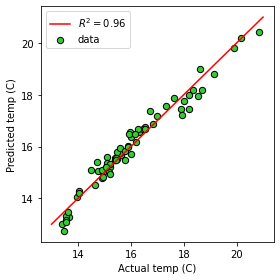

In [5]:
# predictors
X = stats[['dist', 'meanq', 'meanairtemp', 'year']]

# predict water temperature
y = stats['temp']

# mixed linear model formula, log transform flow
formula = 'temp ~  np.log(meanq) + meanairtemp + dist'
mod = smf.mixedlm(formula=formula, data=stats, groups=stats["year"])
model = mod.fit()
predictions = model.predict(X)
coef = model.summary().tables[1]

themax = 21
themin = 13
f,ax = plt.subplots(1,figsize=(4,4))
ax.scatter(y,predictions,s=40,c='limegreen',edgecolors='k', label='data')
ax.plot([themin,themax],[themin,themax],c='r',label=r'$R^2=$'+'%0.2f'%r2_score(y,predictions))
ax.set_ylabel('Predicted temp (C)')
ax.set_xlabel('Actual temp (C)')
ax.legend()
f.tight_layout()
f.savefig('./r2.pdf')
files.download('./r2.pdf')
print('Model coefficients standard errors and confidence intervals:')
coef.to_csv('./fit.csv')
model.summary()

In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

image = '/content/pikeminnow/data/pikeminnow_traced.png'

Max/min temp are 21.6 and 18.6
Distance downstream: 5.8 km 

Max/min temp are 19.0 and 16.0
Distance downstream: 6.8 km 

Max/min temp are 18.1 and 15.2
Distance downstream: 9.9 km 

Max/min temp are 15.5 and 12.6
No pikeminnow predicted in reach 



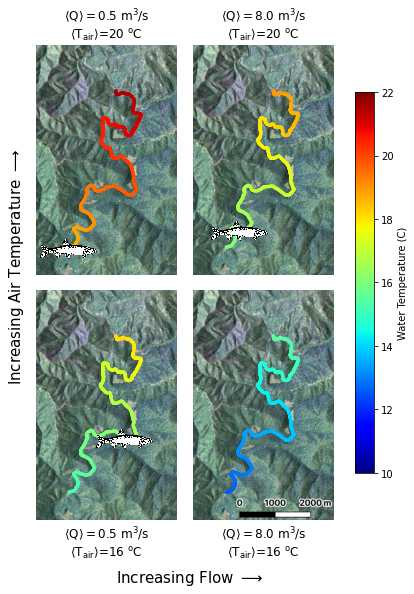

In [0]:
import matplotlib.pyplot as plt
f,axs = plt.subplots(2,2,figsize=(6,8))
axs = axs.flatten()
tempthresh = 16.3
qvals = [0.5,8.0]
tvals = [20,16]
pts_within_data = pts_along_reach.loc[(pts_along_reach.Distance<stats.dist.max())&(pts_along_reach.Distance>stats.dist.min())]
vmin = 10
vmax = 22
counter=0

gdf = gp.GeoDataFrame()

for tval in tvals:
  for qval in qvals:
    tempX = pd.DataFrame({'dist':pts_within_data.Distance})
    tempX['meanq'] = qval
    tempX['meanairtemp'] = tval
    tempX = tempX[['dist', 'meanq', 'meanairtemp']]
    predictions = model.predict(tempX)
    pts_temp = pts_within_data.copy()
    pts_temp['Predicted Temp (C)'] = predictions
    print('Max/min temp are %.1f and %.1f'%(pts_temp['Predicted Temp (C)'].max(),pts_temp['Predicted Temp (C)'].min()))
    ax = axs[counter] 

    if counter==3:
        src = rasterio.open("./pikeminnow/data/imagery_for_plotting_over_scale.tif")
    else:
        src = rasterio.open("./pikeminnow/data/imagery_for_plotting_over.tif")
    show(src.read(), transform=src.transform,ax=ax)
    pts_temp.plot('Predicted Temp (C)',cmap='jet',markersize=5,ax=ax,vmax=vmax,vmin=vmin,legend=False)
    # ax.get_xaxis().set_visible(False)
    # ax.xaxis.set_ticks_position('none') 
    ax.set_xticks([])
    ax.get_yaxis().set_visible(False)
    title = r'$\langle \mathrm{Q} \rangle=$'+'%.1f '%qval + r'm$^3$/s' + '\n' + r'$\langle$T$_{\mathrm{air}} \rangle$' + '=%.0f '%(tval) + r'$^\mathrm{o}$C'
    if counter>=2:
      ax.set_xlabel(title,size=12)
    else: 
      ax.set_title(title)

    
    x = np.array([item.x for item in pts_temp.geometry.values])
    y = np.array([item.y for item in pts_temp.geometry.values])
    z = pts_temp['Predicted Temp (C)'].values

    idx = z > tempthresh
    try: 
      if np.sum(idx)==len(z):
        # x,y = np.nan, np.nan
        x,y = x[idx][0], y[idx][0]
      else:
        x,y = x[idx][0],y[idx][0]
    except:
      x,y = np.nan, np.nan

    imscatter(x, y, image, ax=ax, zoom=0.02)
    try: 
      print('Distance downstream: %.1f km \n'%pts_temp.Distance.values[idx][0])
    except:
      print('No pikeminnow predicted in reach \n')
    pt = Point(x,y)
    temp = gp.GeoDataFrame({'Q':qval, 'T':tval},geometry=[pt],index=[counter])
    temp.crs = 'epsg:26910'
    gdf = gdf.append(temp)
    counter = counter + 1

     
# bbox_props = dict(boxstyle="rarrow,pad=0.1",fc="white", ec="k", lw=2)
f.text(0.45, -0.01, "Increasing Flow $\longrightarrow$", ha="center", va="center", size=15)
f.text(0.05, 0.53, r"Increasing Air Temperature $\longrightarrow$", ha="center",va="center", rotation=90,size=15)

f.tight_layout()
sns.despine(fig=f,top=True,right=True,bottom=True,left=True)
for ax in axs:
  sns.despine(ax=ax,top=True, bottom=True, right=True, left=True)
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=vmin, vmax=vmax))
f.colorbar(sm, ax=axs[:], shrink=0.8, location='right',label='Water Temperature (C)',ticks = np.arange(vmin,vmax+1,2))
gdf.to_file('./threshold_locations_16point3.shp')
f.savefig('./stats_model_map.png',dpi=400,bbox_inches='tight')
files.download('stats_model_map.png')


In [0]:
pts_temp.head()

,Distance t,id,Distance,geometry,Predicted Temp (C)
550,126048.309593,550,5.764100,POINT (444089.944 4396777.349),12.584426
551,126035.413125,551,5.776996,POINT (444099.063 4396786.468),12.587966
552,126026.293945,552,5.786116,POINT (444108.182 4396786.468),12.590470
553,126017.174766,553,5.795235,POINT (444117.301 4396786.468),12.592974
554,126004.278298,554,5.808131,POINT (444126.420 4396795.587),12.596514


pool Lower: 9.6
pool Crawl's: 3.2
pool Hunter's: 14.9
pool Rattlesnake: 27.7
pool Wilderness: 10.7


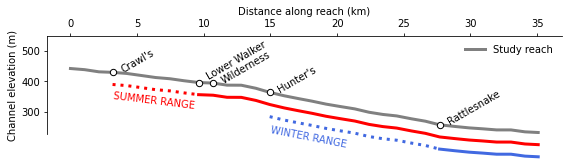

In [0]:
pts_mapfig = gp.read_file('./pikeminnow/data/pts_mapfig.shp')
f = './pikeminnow/data/clipped_compressed.tif'
ptslist = [(item.x, item.y) for item in pts_mapfig.geometry.values]
skip = 100
idxs = [item for item in range(len(ptslist)) if np.mod(item,skip)==0]
vals = np.ones(len(ptslist))*np.nan
with rasterio.open(f) as src:
    for idx in idxs:
        vals[idx] = [item for item in src.sample([ptslist[idx]])][0]

pts_mapfig['Elevation'] = vals
idx = pts_mapfig.index[pts_mapfig.Elevation>0]
pts_mapfig = pts_mapfig.loc[idx]
pools = gp.read_file('./pikeminnow/data/pools.shp')
pooldists = []
poolelevs = []
poollabels = []
nodes = np.array([(item.x, item.y) for item in pts_mapfig.geometry])
idxs = []
for i,row in pools.iterrows():
  node = (row.geometry.x, row.geometry.y)
  idx = cdist([node], nodes).argmin()
  if idx in idxs:
    idx = idx+1
  idxs.append(idx)
  poolelevs.append(pts_mapfig.iloc[idx].Elevation)
  pooldists.append(pts_mapfig.iloc[idx].Distance)
  if 'Pool' in row.Name:
    poollabels.append(row.Name[:-5])
  else:
    poollabels.append(row.Name)

poolsdf = pd.DataFrame({ 'dist':pooldists, 'elev':poolelevs })
poolsdf.index = poollabels
f,ax = plt.subplots(1,figsize=(8,2.5))
ax.plot(pts_mapfig['Distance'], pts_mapfig.Elevation,c='gray',lw=3, label='Study reach')
ax.set_ylabel('Channel elevation (m)')
ax.set_xlabel('Distance along reach (km)')
ax.scatter(pooldists, poolelevs, s=40,edgecolor='k',lw=1,c='w',zorder=10)
for i in range(len(pooldists)):
  l = poollabels[i].split(' ')[0]
  y = poolelevs[i]
  x = pooldists[i]+0.5
  print("pool %s: %.1f"%(l,x-0.5))
  
  if 'Walker' in poollabels[i]:
    l = 'Lower Walker'
    y = y + 10
  ax.text(x,y,l,rotation=30)

dist_x = pts_mapfig['Distance'].values
elev_y = pts_mapfig['Elevation'].values


dsort = np.sort(pooldists)
x1,x2,x3 = dsort[0], dsort[1], pts_mapfig['Distance'].max()
idx = (dist_x>=x1)&(dist_x<=x2)
m,b = np.polyfit(dist_x[idx], elev_y[idx],deg=1)
fun = lambda x: m*x+b

ax.plot(dist_x[idx], elev_y[idx]-40,clip_on=False,c='r',ls=':',lw=3,label='')
ax.text(dist_x[idx][0], elev_y[idx][0]-120,'SUMMER RANGE',rotation=-7,color='r')
idx = (dist_x>=x2)&(dist_x<=x3)
ax.plot(dist_x[idx], elev_y[idx]-40,clip_on=False,c='r',ls='-',lw=3,label='')


x1,x2,x3 = dsort[3], dsort[4], pts_mapfig['Distance'].max()
idx = (dist_x>=x1)&(dist_x<=x2)
ax.plot(dist_x[idx], elev_y[idx]-80,clip_on=False,c='royalblue',ls=':',lw=3,label='')
ax.text(dist_x[idx][0], elev_y[idx][0]-180,'WINTER RANGE',rotation=-11,color='royalblue')
idx = (dist_x>=x2)&(dist_x<=x3)
ax.plot(dist_x[idx], elev_y[idx]-80,clip_on=False,c='royalblue',ls='-',lw=3,label='')

sns.despine(bottom=True,top=False)
ax.set_ylim([225,550])
ax.xaxis.set_ticks_position('top') # the rest is the same
ax.xaxis.set_label_position('top') 
ax.legend(ncol=1,frameon=False)
f.tight_layout()

f.savefig('./rangeplot.png',bbox_inches='tight',dpi=300)
files.download('rangeplot.png')


In [0]:
pooldists

[9.611496337728575,
 3.157245561423944,
 14.94230101766871,
 27.68616650492161,
 10.699382238893522]